# Algorithms 202: Coursework 2 Task 1: Random Sampling

Group-ID: 53

Group members: zl4214 - Ziyang Liu jw6914 - Jiaying Wang cmc214 - Chai Cheng

## Objectives

The aim of this coursework is to enhance your algorithmic skills by developing algorithms from textual, non-formal descriptions. You are asked to show that you can:

- implement three different random sampling algorithms
- compare those algorithms using visual representations based on image sampling

This notebook *is* the coursework. It contains cells with function definitions that you will need to complete. You will submit this notebook as your coursework.

## Preliminaries: helper functions

Here we define a collection of functions that will be useful for the rest of the coursework. You'll need to run this cell to get started.

In [109]:
%matplotlib inline
import numpy as np
from scipy.ndimage import map_coordinates
from scipy.spatial import cKDTree as KDTree
from matplotlib import pyplot as plt
from PIL import Image

def load_image(path):
    return np.array(Image.open(str(path)))

def sample_colors(image, sample_points):
    r"""
    Sample RGB colour values from an image of shape (w, h, 3)
    at floating point (x, y) sample points.
    """
    r = map_coordinates(image[..., 0], sample_points.T)
    g = map_coordinates(image[..., 1], sample_points.T)
    b = map_coordinates(image[..., 2], sample_points.T)
    return np.vstack((r, g, b)).T

def indices_of_pixels(image):
    r"""(x, y) index values for each pixel in an image.
    """
    return np.indices(image.shape[:2]).reshape([2, -1]).T

def closest_index(sample_points, indices):
    r"""
    Find the nearest sample_point at a given index
    (along with the distance to the point). Input is
    an array of sample_points and an array of indicies to
    test at. Output is array of indices and distances.
    """
    kdtree = KDTree(sample_points)
    distance, index = kdtree.query(indices)
    return index, distance

def resample_image(image, sample_points):
    # for each (floating point) sample_point extract the
    # RGB colour value of the image at that location
    colors = sample_colors(image, sample_points)
    # get all (x, y) index values for each pixel in
    # the image
    indices = indices_of_pixels(image)
    # for every pixel (each index) find the nearest sample
    # point (and the distance, but we don't need it here)
    c_index,_ = closest_index(sample_points, indices)
    # map the closest indexes to colour values - reshape
    # the resulting RGB array back into the original image 
    # shape.
    return colors[c_index].reshape(image.shape)

## Task 1: Random Sampling

In this task you are asked to implement `uniform_sampling`, `best_candidate_sampling` and `poison_disc_sampling`. Additionally, you will need to implement visualising techniques that can be used to compare the output of the three different random sampling algorithms.

Complete the below function definitions in the provided skeleton code. Do not change the names of the functions or their arguments.

### 1a. Implement `uniform_sampling`

The `uniform_sampling` function should produce `n_samples` sample points randomly distributed over the sample domain. See lecture slides for details and pseudo-code. Hint: The sample domain defined by the width and the height of the image can be obtained by `image.shape[:2]`.

In [110]:
import random as random

def uniform_sampling(image, n_samples):
    sample_points = []
    (height, width) = image.shape[:2]
    for i in range(0, n_samples):
        x =  random.random() * width
        y = random.random() * height
        sample_points = sample_points + [(x, y)]
    return np.array(sample_points)

### 1b. Implement `best_candidate_sampling`

The `best_candidate_sampling` function should produce `n_samples` sample points randomly distributed over the sample domain. See lecture slides for details and pseudo-code. Hint: The `best_candidate` function here corresponds to the BEST-CANDIDATE-SAMPLE function in the slides, which generates a single new sample.

In [111]:
def best_candidate_sampling(image, n_samples, n_candidates):
    sample_points = [(0, 0)]
    for i in range(0, n_samples):
        sample_points = sample_points + [best_candidate(image, sample_points, n_candidates)]
    return np.array(sample_points)

def best_candidate(image, samples, n_candidates):
    best_candi = (0, 0)
    best_distance = 0
    (height, width) = image.shape[:2]
    for i in range(0, n_candidates):
        x =  random.random() * width
        y = random.random() * height
        c = (x, y)
        _, d = closest_index(samples, c)
        if d > best_distance:
            best_distance = d
            best_candi = c
    return best_candi

### 1c. Implement `poison_disc_sampling`

The `poison_disc_sampling` function should produce sample points randomly distributed over the sample domain with a minimum distance of `radius`. See lecture slides and [Bridson's original paper](https://www.cs.ubc.ca/~rbridson/docs/bridson-siggraph07-poissondisk.pdf) for details.

In [112]:
import math
import random as random

def poison_disc_sampling(image, radius, n_candidates):
    
    # Creates a list of sample_point, a list of active_list, and the background_grid
    sample_points = []
    active_list = []
    cell_size = int(radius / math.sqrt(2))
    (height, width) = image.shape[:2]
    background_grid = np.ones((height / cell_size, width / cell_size))
    background_grid = background_grid * (-1)
    
    # Create an initial sample and insert it into the lists and background_grid
    x = random.random() * width
    y = random.random() * height
    initial_sample = (x, y)
    (if_contain, index) = check_if_grid_at_index_contain_sample(initial_sample, background_grid, image, cell_size)
    (active_list, sample_points) = add_sample_point_to_list(initial_sample, sample_points, active_list)
    background_grid = add_sample_point_to_grid(sample_points, background_grid, index)
        
    while(not(not(active_list))):
        index = random.randint(0, len(active_list) - 1)
        (xi, yi) = active_list[index]
        point_i = (xi, yi)
        found_sample_point = False
        for k in range(0, n_candidates):
            (test_point, double_radius) = generate_random_anulus_points(point_i, radius)
            with_image = check_if_point_within_image(test_point, image)
            if(not(with_image)):
                continue
            
            _, distance = closest_index(sample_points, test_point)   
                        
            if(distance > radius):
                (if_contain, index) = check_if_grid_at_index_contain_sample(test_point, background_grid, image, cell_size)
                if(not(if_contain)):
                    (active_list, sample_points) = add_sample_point_to_list(test_point, sample_points, active_list)
                    background_grid = add_sample_point_to_grid(sample_points, background_grid, index)
                    found_sample_point = True  
                    
        if(not(found_sample_point)):
            active_list = remove_sample_point(point_i, active_list)
            
    return np.array(sample_points)

def adjust_point_within_image(point, image):
    (height, width) = image.shape[:2]
    (x, y) = point
    if(x < 0):
        x = 0
    elif(x > width - 1):
        x = width - 1
    if(y < 0):
        y = 0
    elif(y > height - 1):
        y = height - 1
    return (x, y)

def check_if_point_within_image(point, image):
    (height, width) = image.shape[:2]
    (x, y) = point
    if(x < 0 or  x > width - 1 or y < 0 or y > height - 1):
        return False
    return True

def add_sample_point_to_list(sample_point, sample_points, active_list):
    sample_points.extend([sample_point])
    active_list.extend([sample_point])
    return(active_list, sample_points)

def add_sample_point_to_grid(sample_points, background_grid, index):
    (i, j) = index
    background_grid[i, j] = len(sample_points) - 1     
    return background_grid

def check_if_grid_at_index_contain_sample(sample_point, background_grid, image, cell_size):
    (height, width) = image.shape[:2]
    (x, y) = sample_point
    (i, j)= (y / cell_size - 1, x / cell_size - 1)
    index = background_grid[i, j]
    if(index != -1):
        return (True, (i, j))
    else:
        return (False, (i, j))
    
def remove_sample_point(sample_point, active_list):
    active_list.remove(sample_point)
    return active_list

def calculate_distance(point1, point2):
    diff_in_x = point2[0] - point1[0]
    diff_in_y = point2[1] - point1[1]
    distance = math.sqrt(diff_in_x**2 + diff_in_y**2)
    return distance

def generate_random_anulus_points(point, radius):
    r1 = random.random()
    r2 = random.random()
    double_radius = radius * (r1 + 1)
    angle = 2 * math.pi * r2
    x = point[0] + double_radius * math.cos(angle)
    y = point[1] + double_radius * math.sin(angle)
    return ((x, y), double_radius)

### Image sampling

The following cells are for testing and visualisation of your sampling methods.

#### Load test image

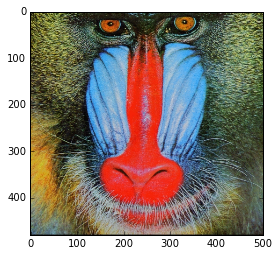

In [113]:
#image= load_image('./brain.png')
#image = load_image('./face.png')
#image = load_image('./lighthouse.png')
image = load_image('./mandrill.png')
#image = load_image('./parrots.png')
#image = load_image('./starry-night.png')
#image = load_image('./synth.png')
plt.imshow(image)

#### Generate random samples

In [114]:
#less samples - good for debugging
samples_uni = uniform_sampling(image, 685)
samples_bc = best_candidate_sampling(image, 685, 10)
samples_pd = poison_disc_sampling(image, 15, 30)

#more samples - looks better
#samples_uni = uniform_sampling(image, 2000)
#samples_bc = best_candidate_sampling(image, 2000, 10)
#samples_pd = poison_disc_sampling(image, 10, 30)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:81: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:74: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


#### Plot samples

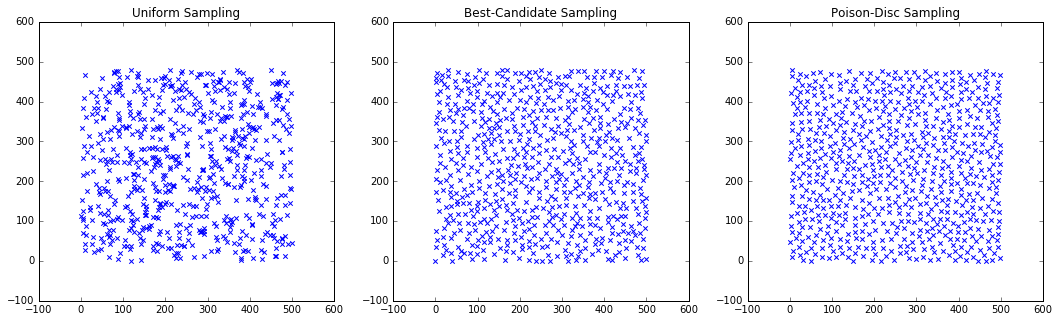

In [115]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))
axs[0].scatter(samples_uni[:,0], samples_uni[:,1], marker='x')
axs[0].set_title('Uniform Sampling')
axs[1].scatter(samples_bc[:,0], samples_bc[:,1], marker='x')
axs[1].set_title('Best-Candidate Sampling')
axs[2].scatter(samples_pd[:,0], samples_pd[:,1], marker='x')
axs[2].set_title('Poison-Disc Sampling')
plt.show()

#### Resample images using random samples

In [116]:
image_uni = resample_image(image, samples_uni)
image_bc = resample_image(image, samples_bc)
image_pd = resample_image(image, samples_pd)

#### Plot images

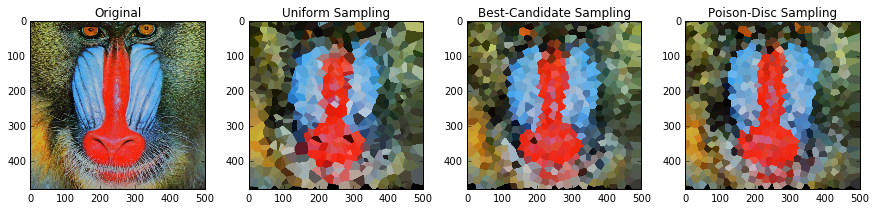

In [117]:
fig, axs = plt.subplots(1, 4, figsize=(15,3))
axs[0].imshow(image)
axs[0].set_title('Original')
axs[1].imshow(image_uni)
axs[1].set_title('Uniform Sampling')
axs[2].imshow(image_bc)
axs[2].set_title('Best-Candidate Sampling')
axs[3].imshow(image_pd)
axs[3].set_title('Poison-Disc Sampling')
plt.show()

### 1d. Implement `distance_map` for colouring image points according to their distance to sample points

The `distance_map` function should generate an image where each pixel intensity is set to the distance to the closest sample point. Hint: You might want to check out the `resample_image` function provided above for guidance.

In [118]:
def distance_map(image, sample_points):
    
    indices = indices_of_pixels(image)
    c_index, distance = closest_index(sample_points, indices)
    (height, width) = image.shape[:2]

    distance_map = np.zeros((height, width, 3))

    for i in range(len(indices)):
        (x, y) = indices[i]
        distance_map[x, y] = distance[i]
        
    colors = sample_colors(distance_map, sample_points)

    return colors[c_index].reshape(image.shape)

#### Generate distance maps using random samples

In [119]:
distmap_uni = distance_map(image, samples_uni)
distmap_bc = distance_map(image, samples_bc)
distmap_pd = distance_map(image, samples_pd)

#### Plot distance maps

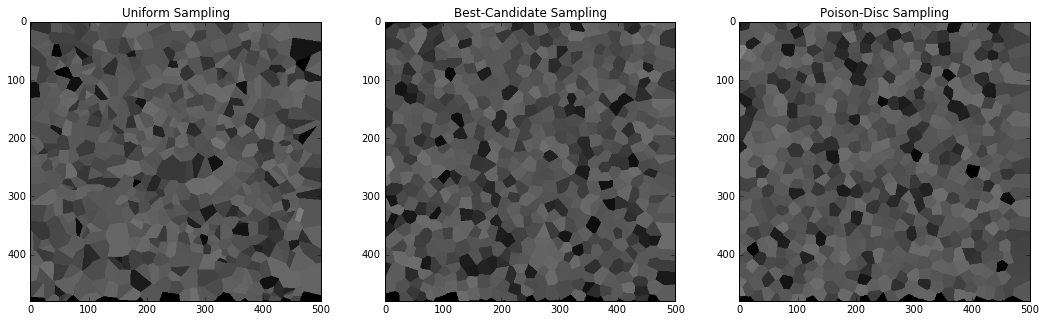

In [120]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))
axs[0].imshow(distmap_uni)
axs[0].set_title('Uniform Sampling')
axs[1].imshow(distmap_bc)
axs[1].set_title('Best-Candidate Sampling')
axs[2].imshow(distmap_pd)
axs[2].set_title('Poison-Disc Sampling')
plt.show()